## ATLAS Open Data Initialisation

### To setup everytime
Run imports

In [1]:
import uproot # for reading .root files
import time # to measure time to analyse
import math # for mathematical functions such as square root
import pandas as pd # for csv handling
import awkward as ak # for handling complex and nested data structures efficiently
import numpy as np # # for numerical calculations such as histogramming
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
import vector #to use vectors
import requests # for HTTP access
import aiohttp # HTTP client support


## Example 1: Reading data 

Data has previously been downloaded, but we recreate the list of samples using the same code

In [3]:
import atlasopenmagic as atom
atom.available_releases()
atom.set_release('2025e-13tev-beta')

Available releases:
2016e-8tev        2016 Open Data for education release of 8 TeV proton-proton collisions (https://opendata.cern.ch/record/3860).
2020e-13tev       2020 Open Data for education release of 13 TeV proton-proton collisions (https://cern.ch/2r7xt).
2024r-pp          2024 Open Data for research release for proton-proton collisions (https://opendata.cern.record/80020).
2024r-hi          2024 Open Data for research release for heavy-ion collisions (https://opendata.cern.ch/record/80035).
2025e-13tev-beta  2025 Open Data for education and outreach beta release for 13 TeV proton-proton collisions (https://opendata.cern.ch/record/93910).
2025r-evgen       2025 Open Data for research release for event generation (https://opendata.cern.ch/record/160000).
Active release set to: 2025e-13tev-beta. Metadata cache cleared.


We would like to load the Open Data ntuples which already have been selected (skimmed) to contain at least two photons.

In [4]:
# Select the skim to use for the analysis
skim = "GamGam"

The data is organized by the collection periods throughout the year. In this notebook, we will use the 2015 data from periods D, E, F, G, H, and J, as well as the 2016 data from periods A, B, C, D, E, F, G, K, and L.

In [6]:
samples_list = atom.build_data_dataset(skim, protocol='https')

Fetching and caching all metadata for release: 2025e-13tev-beta...
Successfully cached 374 datasets.


Depending on the analysis, some variables are more revelant than others, providing directly or indirectly better discrimination of the signal with respect to the backgrounds than others.
The most important variables for the $H \rightarrow \gamma\gamma$ analysis can be stored in a list and retrieved later from the tree, and correspond to the following:

In [4]:
variables = ["photon_pt","photon_eta","photon_phi","photon_e",
                            "photon_isTightID","photon_ptcone20"]

Functions to cut the data and calculate the resulting invariant mass

In [5]:
# Cut on the photon reconstruction quality
def cut_photon_reconstruction(photon_isTightID):
    # Only the events which have True for both photons are kept
    return (photon_isTightID[:,0]==False) | (photon_isTightID[:,1]==False) 

# Cut on the transverse momentum
def cut_photon_pt(photon_pt):
# Only the events where photon_pt[0] > 50 GeV and photon_pt[1] > 30 GeV are kept
    return (photon_pt[:,0] < 50) | (photon_pt[:,1] < 30)

# Cut on the energy isolation
def cut_isolation_pt(photon_ptcone20, photon_pt):
# Only the events where the calorimeter isolation is less than 5.5% are kept
    return ((photon_ptcone20[:,0]/photon_pt[:,0]) > 0.055) | ((photon_ptcone20[:,1]/photon_pt[:,1]) > 0.055)

# Cut on the pseudorapidity in barrel/end-cap transition region
def cut_photon_eta_transition(photon_eta):
# Only the events where modulus of photon_eta is outside the range 1.37 to 1.52 are kept
    condition_0 = (np.abs(photon_eta[:, 0]) < 1.52) & (np.abs(photon_eta[:, 0]) > 1.37)
    condition_1 = (np.abs(photon_eta[:, 1]) < 1.52) & (np.abs(photon_eta[:, 1]) > 1.37)
    return condition_0 | condition_1

# This function calculates the invariant mass of the 2-photon state
def calc_mass(photon_pt, photon_eta, photon_phi, photon_e):
    p4 = vector.zip({"pt": photon_pt, "eta": photon_eta, "phi": photon_phi, "e": photon_e})
    invariant_mass = (p4[:, 0] + p4[:, 1]).M # .M calculates the invariant mass
    return invariant_mass

# Cut on null diphoton invariant mass
def cut_mass(invariant_mass):
    return (invariant_mass == 0)

# Cut on diphoton invariant mass based isolation 
# Only the events where the invididual photon invariant mass based isolation is larger than 35% are kept
def cut_iso_mass(photon_pt, invariant_mass):
    return ((photon_pt[:,0]/invariant_mass) < 0.35) | ((photon_pt[:,1]/invariant_mass) < 0.35)

## Final Analysis

For the final analysis, we'll begin by applying the cuts and calculating the invariant masses across all the data. Once that's done, we'll fit the data to uncover the Higgs boson peak. Let's kick things off by applying the cuts and calculating those invariant masses!

In [ ]:
# # Controls the fraction of all the events analysed
# fraction = 1 # all of the data is used to run this analysis (implemented in the loop over the tree)
#              # reduce this if you want the code to run quicker

# all_data = []
# sample_data = []

# # Loop over each file
# for val in samples_list['Data']['list']: 

#     # Print which sample is being processed
#     print('Processing '+val+' samples')

#     fileString = val# file name to open

#     # Open file
#     if local_files:
#         # Download the file, use a local copy
#         local_filename = fileString.split("/")[-1]
#         print(f"Downloading {fileString} to {local_filename} ...")
#         with requests.get(fileString, stream=True) as r:
#             r.raise_for_status()
#             with open(local_filename, "wb") as f:
#                 for chunk in r.iter_content(chunk_size=8192):
#                     f.write(chunk)
#         tree = uproot.open(local_filename + ":analysis")
#     else: # Stream files
#         tree = uproot.open(fileString + ":analysis")

#     numevents = tree.num_entries

#     # Perform the cuts for each data entry in the tree and calculate the invariant mass
#     for data in tree.iterate(variables, library="ak", entry_stop=numevents*fraction):

#         photon_isTightID = data['photon_isTightID']
#         data = data[~cut_photon_reconstruction(photon_isTightID)]
        
#         photon_pt = data['photon_pt']
#         data = data[~cut_photon_pt(photon_pt)]

#         data = data[~cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

#         photon_eta = data['photon_eta']
#         data = data[~cut_photon_eta_transition(photon_eta)]
        
#         data['mass'] = calc_mass(data['photon_pt'], data['photon_eta'], data['photon_phi'], data['photon_e'])

#         data = data[~cut_mass(data['mass'])]

#         data = data[~cut_iso_mass(data['photon_pt'], data['mass'])]
        
#         # Append data to the whole sample data list
#         sample_data.append(data['mass'])
        
# # turns sample_data back into an awkward array
# all_data = ak.concatenate(sample_data)

In [48]:
# Controls the fraction of all the events analysed
fraction = 1 # all of the data is used to run this analysis (implemented in the loop over the tree)
             # reduce this if you want the code to run quicker

all_data = []
sample_data = []

# Name for the output CSV file
csv_filename = 'unfiltered_photon_data.csv'

# Flag to handle the header: we only want to write it for the first chunk
is_first_chunk = True

# Loop over each file
for val in samples_list['Data']['list']: 

    # Print which sample is being processed
    print('Processing '+val+' samples')

    fileString = val# file name to open

    tree = uproot.open(local_filename + ":analysis")

    numevents = tree.num_entries

    # Perform the cuts for each data entry in the tree
    for data in tree.iterate(variables, library="ak"):

#         # data[~boolean] is used to remove entries from the data set
#         photon_isTightID = data['photon_isTightID']
#         data = data[~cut_photon_reconstruction(photon_isTightID)]

#         photon_pt = data['photon_pt']
#         data = data[~cut_photon_pt(photon_pt)]

#         data = data[~cut_isolation_pt(data['photon_ptcone20'],data['photon_pt'])]

#         photon_eta = data['photon_eta']
#         data = data[~cut_photon_eta_transition(photon_eta)]

        # If there are any events left in the chunk after cutting...
        if len(data) > 0:
            # Convert the filtered awkward array chunk to a pandas DataFrame.
            # This "flattens" the data so it's suitable for a CSV.
            df = ak.to_dataframe(data)

            # If it's the first chunk, write to the file with a header.
            # 'mode='w'' means write (and will overwrite any existing file).
            if is_first_chunk:
                df.to_csv(csv_filename, mode='w', header=True, index=False)
                # Set the flag to False so headers aren't written again
                is_first_chunk = False
            # For all subsequent chunks, append to the file without a header.
            # 'mode='a'' means append.
            else:
                df.to_csv(csv_filename, mode='a', header=False, index=False)

Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodD.GamGam.root samples
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodE.GamGam.root samples
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodF.GamGam.root samples
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodG.GamGam.root samples
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodH.GamGam.root samples
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data15_periodJ.GamGam.root samples
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data16_periodA.GamGam.root samples
Processing https://opendata.cern.ch/eos/opendata/atlas/rucio/opendata/ODEO_FEB2025_v0_GamGam_data16_peri

We are now ready to fit our data to effectively detect the Higgs boson! We will use a combination of a 4th order polynomial and a Gaussian function. The polynomial function represents the background, while the Gaussian function represents our signal. The Gaussian model is used to fit the signal due to the nature of the detector's resolution. The fourth-order polynomial is chosen for the background because it offers enough flexibility to capture the overall shape without overfitting, thereby reducing the influence of spurious data—random, irrelevant fluctuations or noise that do not correspond to the true signal or background.

In [ ]:
df = pd.read_csv("unfiltered_photon_data.csv")
data = df.to_numpy()

data = df.values.astype(np.float64)
names = df.columns.values.astype('<U68')

# Save as .npz file
np.savez_compressed("unfiltered_photon_data_all_periods.npz", data=data, names=names)

# Now load data in Baler, train and compress model before pulling back in to re-run the experiment

In [20]:
# Step 1: Load data from the .npz file
npz_filename = 'photons_decompressed.npz'
print(f"Loading data from '{npz_filename}'...")

with np.load(npz_filename) as f:
    flat_data = f['data']
    column_names = f['names']

print(f"Loaded flat data with shape: {flat_data.shape}")

# Step 2: Reshape the data to reconstruct the event structure
# We assume 2 photons per event.
n_photons_per_event = 2
if flat_data.shape[0] % n_photons_per_event != 0:
    raise ValueError("Number of rows is not divisible by 2. Cannot reshape.")
    
n_events = flat_data.shape[0] // n_photons_per_event
n_features = flat_data.shape[1]
event_data = flat_data.reshape((n_events, n_photons_per_event, n_features))

print(f"Reshaped into event data with shape (events, photons, features): {event_data.shape}")

# Step 3: Extract columns. They will now have the shape (n_events, 2)
name_to_idx = {name: i for i, name in enumerate(column_names)}

photon_pt         = event_data[:, :, name_to_idx['photon_pt']]
photon_eta        = event_data[:, :, name_to_idx['photon_eta']]
photon_phi        = event_data[:, :, name_to_idx['photon_phi']]
photon_e          = event_data[:, :, name_to_idx['photon_e']]
photon_isTightID  = event_data[:, :, name_to_idx['photon_isTightID']].astype(bool) # Ensure boolean type
photon_ptcone20   = event_data[:, :, name_to_idx['photon_ptcone20']]

# Step 4: Perform calculations
all_masses = calc_mass(photon_pt, photon_eta, photon_phi, photon_e)

# Step 5: Apply all cuts by creating a boolean mask for each
# Note: The '~' inverts the mask, keeping events where the cut function returns False.
print("\nApplying cuts...")
mask_reco     = ~cut_photon_reconstruction(photon_isTightID)
mask_pt       = ~cut_photon_pt(photon_pt)
mask_iso_pt   = ~cut_isolation_pt(photon_ptcone20, photon_pt)
mask_eta      = ~cut_photon_eta_transition(photon_eta)
mask_mass_val = ~cut_mass(all_masses)
mask_iso_mass = ~cut_iso_mass(photon_pt, all_masses)

# Combine all masks into a single final mask
final_mask = (
    mask_reco & 
    mask_pt & 
    mask_iso_pt & 
    mask_eta & 
    mask_mass_val & 
    mask_iso_mass
)

# Apply the final mask to the mass array
final_mass_values = all_masses[final_mask]

print(f"Initial number of events: {n_events}")
print(f"Number of events after all cuts: {len(final_mass_values)}")

# turn sample_data back into an awkward array
data15_periodD = ak.concatenate(sample_data)

# # Step 6: Histogram the final, filtered data
# # x-axis range of the plot
# xmin = 100 #GeV
# xmax = 160 #GeV

# # Histogram bin setup
# step_size = 1 #GeV
# bin_edges = np.arange(start=xmin, # The interval includes this value
#                     stop=xmax+step_size, # The interval doesn't include this value
#                     step=step_size ) # Spacing between values
# bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
#                         stop=xmax+step_size/2, # The interval doesn't include this value
#                         step=step_size ) # Spacing between values
# data_x, _ = np.histogram(final_mass_values, bins=bin_edges)
# data_x_errors = np.sqrt(data_x) # Statistical error on the data

# print("\n--- Results ---")
# print("Histogram Bin Counts (data_x):\n", data_x)
# print("Statistical Errors (data_x_errors):\n", data_x_errors)

Loading data from 'photons_decompressed.npz'...
Loaded flat data with shape: (564448, 6)
Reshaped into event data with shape (events, photons, features): (282224, 2, 6)

Applying cuts...
Initial number of events: 282224
Number of events after all cuts: 72016


TypeError: reduce() of empty iterable with no initial value

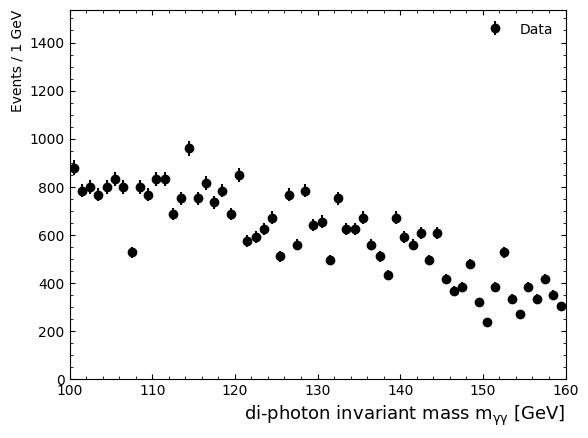

In [18]:
# x-axis range of the plot
xmin = 100 #GeV
xmax = 160 #GeV

# Histogram bin setup
step_size = 1 #GeV
bin_edges = np.arange(start=xmin, # The interval includes this value
                    stop=xmax+step_size, # The interval doesn't include this value
                    step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                        stop=xmax+step_size/2, # The interval doesn't include this value
                        step=step_size ) # Spacing between values

# Creating histogram from data
data_x,_ = np.histogram(ak.to_numpy(data15_periodD), 
                        bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt( data_x ) # statistical error on the data


# *************
# Main plot 
# *************
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                    fmt='ko', # 'k' means black and 'o' is for circles 
                    label='Data') 

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                        direction='in', # Put ticks inside and outside the axes
                        top=True, # draw ticks on the top axis
                        right=True ) # draw ticks on right axis

# x-axis label
main_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                    fontsize=13, x=1, horizontalalignment='right' )

# write y-axis label for main axes
main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                        y=1, horizontalalignment='right') 

# set y-axis limits for main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )

# add minor ticks on y-axis for main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# draw the legend
main_axes.legend( frameon=False ); # no box around the legend

In [19]:

# data_x,_ = np.histogram(ak.to_numpy(all_data), 
#                             bins=bin_edges ) # histogram the data
# data_x_errors = np.sqrt( data_x ) # statistical error on the data

# data fit
polynomial_mod = PolynomialModel( 4 ) # 4th order polynomial
gaussian_mod = GaussianModel() # Gaussian

# set initial guesses for the parameters of the polynomial model
# c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
pars = polynomial_mod.guess(data_x, # data to use to guess parameter values
                            x=bin_centres, c0=data_x.max(), c1=0,
                            c2=0, c3=0, c4=0 )

# set initial guesses for the parameters of the Gaussian model
pars += gaussian_mod.guess(data_x, # data to use to guess parameter values
                        x=bin_centres, amplitude=100, 
                        center=125, sigma=2 )

model = polynomial_mod + gaussian_mod # combined model

# fit the model to the data
out = model.fit(data_x, # data to be fit
                pars, # guesses for the parameters
                x=bin_centres, weights=1/data_x_errors ) #ASK

# background part of fit
params_dict = out.params.valuesdict() # get the parameters from the fit to data
c0 = params_dict['c0'] # c0 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c1 = params_dict['c1'] # c1 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c2 = params_dict['c2'] # c2 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c3 = params_dict['c3'] # c3 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4
c4 = params_dict['c4'] # c4 of c0 + c1*x + c2*x^2 + c3*x^3 + c4*x^4

# get the background only part of the fit to data
background = c0 + c1*bin_centres + c2*bin_centres**2 + c3*bin_centres**3 + c4*bin_centres**4

# data fit - background fit = signal fit
signal_x = data_x - background 

# *************
# Main plot 
# *************
plt.axes([0.1,0.3,0.85,0.65]) # left, bottom, width, height 
main_axes = plt.gca() # get current axes

# plot the data points
main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors, 
                fmt='ko', # 'k' means black and 'o' means circles
                label='Data', markersize=4 ) 

# plot the signal + background fit
main_axes.plot(bin_centres, # x
            out.best_fit, # y
            '-r', # single red line
            label='Sig+Bkg Fit ($m_H=125$ GeV)' )

# plot the background only fit
main_axes.plot(bin_centres, # x
            background, # y
            '--r', # dashed red line
            label='Bkg (4th order polynomial)' )

# set the x-limit of the main axes
main_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x-axis minor ticks
main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# set the axis tick parameters for the main axes
main_axes.tick_params(which='both', # ticks on both x and y axes
                    direction='in', # Put ticks inside and outside the axes
                    top=True, # draw ticks on the top axis
                    labelbottom=False, # don't draw tick labels on bottom axis
                    right=True ) # draw ticks on right axis

# write y-axis label for main 
main_axes.set_ylabel('Events / '+str(step_size)+' GeV', 
                    horizontalalignment='right') 

# set the y-axis limit for the main axes
main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5 ) 

# set minor ticks on the y-axis of the main axes
main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# avoid displaying y=0 on the main axes
main_axes.yaxis.get_major_ticks()[0].set_visible(False) 

# Add text 'ATLAS Open Data' on plot
plt.text(0.2, # x
        0.92, # y
        'ATLAS Open Data', # text
        transform=main_axes.transAxes, # coordinate system used is that of main_axes
        fontsize=13 ) 

# Add text 'for education' on plot
plt.text(0.2, # x
        0.86, # y
        'for education', # text
        transform=main_axes.transAxes, # coordinate system used is that of main_axes
        style='italic',
        fontsize=8 ) 

lumi = 36.1
lumi_used = str(lumi*fraction) # luminosity to write on the plot
plt.text(0.2, # x
        0.8, # y
        '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
        transform=main_axes.transAxes ) # coordinate system used is that of main_axes 

# Add a label for the analysis carried out
plt.text(0.2, # x
        0.74, # y
        r'$H \rightarrow \gamma\gamma$', # text 
        transform=main_axes.transAxes ) # coordinate system used is that of main_axes

# draw the legend
main_axes.legend(frameon=False, # no box around the legend
                loc='lower left' ) # legend location 


# *************
# Data-Bkg plot 
# *************
plt.axes([0.1,0.1,0.85,0.2]) # left, bottom, width, height
sub_axes = plt.gca() # get the current axes

# set the y axis to be symmetric about Data-Background=0
sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                            symmetric=True) )

# plot Data-Background
sub_axes.errorbar(x=bin_centres, y=signal_x, yerr=data_x_errors,
                fmt='ko',markersize=4 ) # 'k' means black and 'o' means circles

# draw the fit to data
sub_axes.plot(bin_centres, # x
            out.best_fit-background, # y
            '-r' ) # single red line

# draw the background only fit
sub_axes.plot(bin_centres, # x
            background-background, # y
            '--r' )  # dashed red line

# set the x-axis limits on the sub axes
sub_axes.set_xlim( left=xmin, right=xmax ) 

# separation of x-axis minor ticks
sub_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 

# x-axis label
sub_axes.set_xlabel(r'di-photon invariant mass $\mathrm{m_{\gamma\gamma}}$ [GeV]',
                    x=1, horizontalalignment='right', 
                    fontsize=13 ) 

# set the tick parameters for the sub axes
sub_axes.tick_params(which='both', # ticks on both x and y axes
                    direction='in', # Put ticks inside and outside the axes
                    top=True, # draw ticks on the top axis
                    right=True ) # draw ticks on right axis 

# separation of y-axis minor ticks
sub_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

# y-axis label on the sub axes
sub_axes.set_ylabel( 'Events-Bkg' ) 


# Generic features for both plots
main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

AttributeError: no field named 'max'

And there it is — a clear peak in the invariant mass spectrum around 125 GeV, signaling the presence of the Higgs boson!

This represents a very close result to the one obtained by ATLAS in [Higgs decay to photons measurement paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.052005), which can be seen below:
<CENTER><img src="images/ImagesHiggs/HyyPaper.png" style="width:50%"></CENTER>

While our main task may be done, there's still more to explore. Here are some additional tasks you can try with this notebook:
* Check how many events are being thrown away by each cut in '[Applying a cut](#applying_cut)'
* Add more cuts from the [Higgs boson discovery paper](https://www.sciencedirect.com/science/article/pii/S037026931200857X#se0090) or the [Higgs decay to photons measurement paper](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.98.052005) in '[Changing a cut](#changing_cut)' and '[Applying a cut](#applying_cut)'
* Find the reduced chi-squared for the fit in '[Plotting](#plotting)'
* Find the mean of the fitted Gaussian in '[Plotting](#plotting)'
* Find the width of the fitted Gaussian in '[Plotting](#plotting)'
* Try different initial guesses for the parameters of the fit in '[Plotting](#plotting)'
* Try different functions for the fit in '[Plotting](#plotting)'
* Your idea!